# Discussão

## Introdução

Os algoritmos genéticos são utilizados como métodos de otimização e são inspirados no processo de seleção natural. São úteis para resolver problemas complexos onde a busca exaustiva (ex: busca em grade) é muito custosa computacionalmente. O algoritmo apresentado neste código foi desenhado para resolver problemas de caminhos em grafos, como encontrar o caminho de menor distância entre dois vértices em um grafo. A seguir, discutiremos a escolha deste tipo de algoritmo e falaremos melhor sobre seu funcionamento

## Funcionamento

### 1. **Geração do Grafo e do Caminho Inicial**

O algoritmo começa com a geração de um grafo a partir dessas duas funções:
- `generate_graph_from_path(num_vertices)`: Gera o grafo a partir de um caminho de vértices, adicionando arestas aleatórias para os vértices intermediários.

In [ ]:
def generate_graph_from_path(num_vertices):
    """
    Gera um grafo a partir de um caminho linear de vértices.

    Args:
    num_vertices (int): Número de vértices no caminho.

    Returns:
    G (networkx.Graph): Grafo gerado.
    path_vertices (list): Lista de vértices no caminho.
    """
    # Define os vértices do caminho de A até B
    path_vertices = ['A'] + [str(i) for i in range(1, num_vertices-1)] + ['B']
    
    # Cria um dicionário para representar o grafo
    path_dict = {}
    for i in range(len(path_vertices)-1):
        if path_vertices[i] not in path_dict:
            path_dict[path_vertices[i]] = {}
        path_dict[path_vertices[i]][path_vertices[i+1]] = random.randint(1, 10)
    
    # Adiciona arestas aleatórias para os vértices restantes
    for i in range(1, num_vertices-1):
        neighbors = random.sample(path_vertices[:i] + path_vertices[i+1:], random.randint(1, num_vertices-2))
        if path_vertices[i] not in path_dict:
            path_dict[path_vertices[i]] = {}
        for neighbor in neighbors:
            if neighbor not in path_dict[path_vertices[i]]:
                path_dict[path_vertices[i]][neighbor] = random.randint(1, 10)
            if neighbor not in path_dict:
                path_dict[neighbor] = {}
            path_dict[neighbor][path_vertices[i]] = path_dict[path_vertices[i]][neighbor]  # Aresta bidirecional
    
    G = nx.Graph()
    
    # Adiciona os vértices e arestas ao grafo
    for node, edges in path_dict.items():
        for neighbor, distance in edges.items():
            G.add_edge(node, neighbor, weight=distance)
    
    print(path_dict)
    return G, path_vertices

### 2. **Plotagem do Grafo**

A função `plot_graph(G)` é utilizada para visualizar o grafo gerado.

### 3. **Geração de Caminhos Aleatórios**

Para iniciar a população de soluções, a função `populacao_de_caminhos(G, start_vertex, end_vertex, n)` foi utilizada. Ela gera `n` caminhos aleatórios a partir de um vértice de início (`start_vertex`) até um vértice de destino (`end_vertex`). Essa população inicial é crucial para a diversidade do algoritmo genético.

### 4. **Função Objetivo**

In [ ]:
def funcao_objetivo_grafo(populacao, G):
    """
    Computa a função objetivo de uma população de caminhos de grafos.

    Args:
    populacao (list): Lista contendo os indivíduos do problema.
    G (networkx.Graph): Grafo contendo os caminhos.

    Returns:
    fitness (list): Lista de valores de aptidão (distância total) para cada caminho.
    """
    fitness = []

    for individuo in populacao:
        #Coleta a distãncia total do caminho do indivíduo
        fitness.append(calculate_path_distance(G, individuo))

    return fitness

#### Escolha da Função Objetivo para Minimização
A função `funcao_objetivo_grafo(populacao, G)` calcula a função objetivo para cada caminho na população, que é a distância total do caminho. Fizemos a escolha de minimizar porque o objetivo é encontrar o caminho mais curto entre dois vértices. Minimizar a função objetivo leva à solução ótima, que é o menor caminho possível. A função `calculate_path_distance(G, path)` é utilizada para somar as distâncias em determinado caminho.

### 5. Seleção por Torneio

In [ ]:
def selecao_torneio_min(populacao, fitness, tamanho_torneio):
    """
    Faz a seleção de uma população usando torneio.

    Nota: da forma que está implementada, só funciona em problemas de minimização.

    Args:
    populacao (list): Lista contendo os indivíduos do problema.
    fitness (list): Lista contendo os valores computados da função objetivo.
    tamanho_torneio (int): Quantidade de indivíduos que batalham entre si.

    Returns:
    selecionados (list): Lista de indivíduos selecionados.
    """
    selecionados = []

    for _ in range(len(populacao)):
        sorteados = random.sample(populacao, tamanho_torneio)

        fitness_sorteados = []
        for individuo in sorteados:
            indice_individuo = populacao.index(individuo)
            fitness_sorteados.append(fitness[indice_individuo])

        min_fitness = min(fitness_sorteados)
        indice_min_fitness = fitness_sorteados.index(min_fitness)
        individuo_selecionado = sorteados[indice_min_fitness]

        selecionados.append(individuo_selecionado)

    return selecionados

#### Por que Seleção por Torneio?
A seleção dos indivíduos para a próxima geração é realizada pela função `selecao_torneio_min(populacao, fitness, tamanho_torneio)`. A seleção por torneio é muito interessante para esse cado pois ela selecionará os melhores indivíduos de um subconjunto aleatório da população. Isso faz com que ela seja eficiente porque:

- **Competitividade:** A seleção por torneio promove a competição entre indivíduos, permitindo que os indivíduos com o melhor material genético tenham vantagens na seleção.
- **Diversidade:** Mantém a diversidade genética na população, reduzindo o risco de convergência prematura.

### 6. Cruzamento

In [ ]:
def cruzamento_cruzado(pai, mae, chance_de_cruzamento):
    """
    Gera um cruzamento entre dois indivíduos inspirado em um corte duplo, mas situacional.

    Args:
    pai (list): indivíduo pai.
    mae (list): indivíduo mãe.
    chance_de_cruzamento (float): chance de ocorrer o cruzamento (0 a 1).

    Returns:
    tuple: Dois indivíduos resultantes do cruzamento ou os indivíduos originais.
    """
    if random.random() < chance_de_cruzamento:
        # Excluir índices iniciais, finais, segundo e penúltimo
        pai_validos = pai[2:-2]
        mae_validos = mae[2:-2]
        
        # Encontrar interseção dos vértices válidos
        pontos_comuns = set(pai_validos).intersection(mae_validos)
        
        if pontos_comuns:
            ponto_de_corte = random.choice(list(pontos_comuns))
            
            # Encontrar os índices reais no pai e na mãe
            indice_pai = pai.index(ponto_de_corte)
            indice_mae = mae.index(ponto_de_corte)
            
            # Realizar o cruzamento
            filho1 = pai[:indice_pai] + mae[indice_mae:]
            filho2 = mae[:indice_mae] + pai[indice_pai:]
            
            return filho1, filho2
        
    return pai, mae

#### Por que o Cruzamento Cruzado?
A função `cruzamento_cruzado(pai, mae, chance_de_cruzamento)` realiza o cruzamento entre dois indivíduos (pai e mãe) com uma certa chance. O cruzamento cruzado, onde um ponto de corte comum é escolhido nos dois pais, foi escolhido porque:

- **Garantia de Validade:** Esse método garante que os filhos resultantes sejam caminhos válidos no grafo.
- **Exploração de Novas Soluções:** Também promove a exploração de novas soluções combinando partes de caminhos diferentes. Tornado-se assim um método simples e eficaz de ser implementado.

### 7. **Mutação**

In [ ]:
def mutacao_troca_caminho(G, populacao, chance_de_mutacao, end_vertex):
    """
    Aplica mutação de troca em um indivíduo.

    Args:
    G (networkx.Graph): Grafo contendo os vértices.
    populacao (list): Lista contendo os indivíduos do problema.
    chance_de_mutacao (float): Chance de mutação (entre 0 e 1).
    end_vertex: Vértice de destino.
    """
    for individuo in populacao:
        if random.random() < chance_de_mutacao:
            # Seleciona um gene aleatório para mutação (exceto o início e o fim)
            gene = random.randint(1, len(individuo) - 2)
            start_vertex = individuo[gene]
            
            # Gera um novo caminho a partir do ponto de mutação até o final
            novo_caminho = gerar_caminho(G, start_vertex, end_vertex)
            individuo = individuo[:gene-1] + novo_caminho

#### Por que a Mutação por Troca?
A mutação é realizada pela função `mutacao_troca(G, populacao, chance_de_mutacao, end_vertex)`, onde um gene (vértice) aleatório de um indivíduo pode ser substituído por um novo caminho gerado a partir desse ponto até o final. Esse tipo de mutação foi escolhido porque:

- **Simples e Direta**: É fácil de implementar e entender.
- **Introdução de Novas Soluções**: Além de introduzir mais variablidade de soluções no espaço, ajuda a escapar de mínimos locais em certos casos.

## Considerações Finais

Os algoritmos genéticos são uma ótima abordagem para problemas otimização (especialmente os mais complexos), como a busca de caminhos em grafos. Cada componente do AG (seleção, cruzamento, mutação) fornece uma vantagem única de exploração do problema. Consideramos que a implementação deste AG é adequada para resolver eficientemente o problema proposto, combinando praticidade de implementação com robustez necessária para problemas de otimização em grafos.

## Abordagem futura


### Implementação desse algoritmo para Modelagem de Cidades como Grafos
Utilizando OSMnx, podemos modelar uma cidade como um grafo, onde:

- **Vértices:** representam interseções ou pontos notáveis.
- **Arestas:** representam ruas ou rotas, ponderadas por distâncias, tempos de viagem ou outros custos relevantes.

In [2]:
import osmnx as ox

# Obtendo grafo da cidade
G = ox.graph_from_place('Maputo, Mozambique', network_type='drive')

# Convertendo para Graph do NetworkX
G = ox.project_graph(G)

In [3]:
G

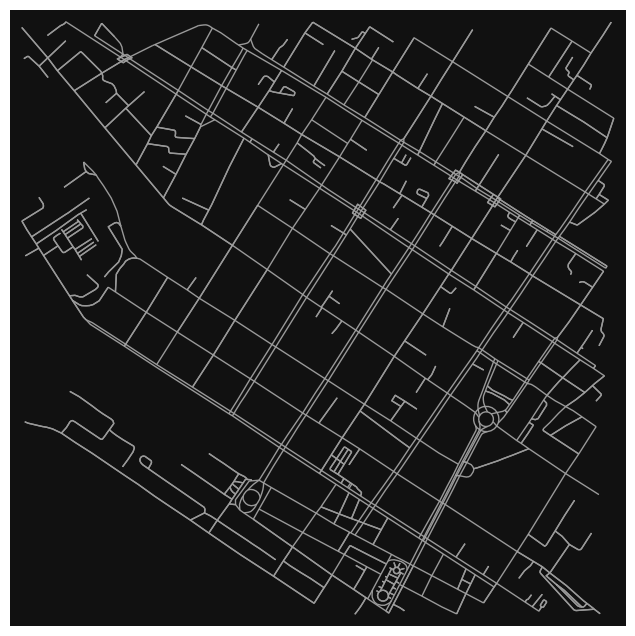

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
G = ox.graph_from_address('Maputo, Mozambique')
ox.plot_graph(G, node_size = 0.1)